In [49]:
using Plots
using QuadGK
using Roots
include("./ring_np_num.jl")
gr()

Plots.GRBackend()

Since we now include the detour inconvenience, we can no longer rescale the utility to only depend on one variable. For the simulations below we will use:
$$\Delta U = a-\sqrt{2} b \sqrt{1-cos(\phi-\phi_i)} - 1$$
for the difference in inconvenience

In [50]:
dir = "2_player_full/"
filenames = readdir(dir)
filenames = [x for x in filenames if x[end-3:end] == "jld2"];

In [51]:
a_array = []
b_array = []
share_array = []
match_array = []

for filename in filenames
    result = load_sim(dir*filename)
    a = result[2].a
    b = result[2].b
    push!(a_array, a)
    push!(b_array, b)
    push!(share_array, result[1][1])
    push!(match_array, result[1][2])
end

a_array = reshape(a_array, :, 7)'
b_array = reshape(b_array, :, 7)'
share_array = reshape(share_array, 7, :)
match_array = reshape(match_array, 7, :);

In [52]:
test_result = hvcat(size(share_array)[2], share_array...);

In [53]:
heatmap(test_result, ylabel="a", xlabel="b")

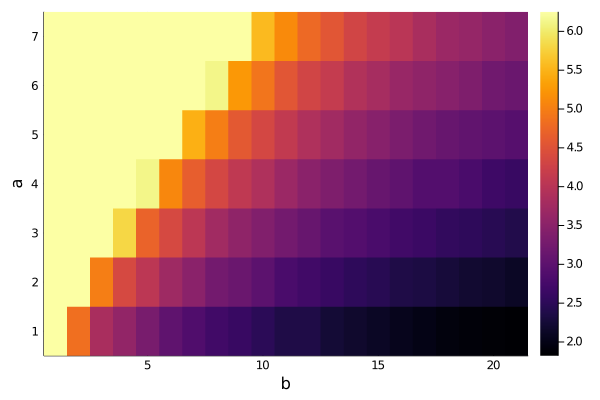

In [54]:
function simple_fitting(ϕ, p, threshold=0.5)
    places = p.>threshold
    larger_range = ϕ[places]
    if length(larger_range) == 0
        return 0, 0
    else
        return larger_range[1], larger_range[end]
    end
    end;

widths = zeros(size(share_array))

ϕ_res = size(share_array[1])[1]
ϕ = LinRange(0,2π, ϕ_res+1)[1:end-1]

for (i, x) in enumerate(share_array)
    params = simple_fitting(ϕ, x[:,end])
    widths[i] = (params[2] - params[1])
end
widths = reshape(widths, 21, 7)'
heatmap(widths, xlabel="b", ylabel="a")

In [55]:
a_array

7×21 LinearAlgebra.Adjoint{Any,Array{Any,2}}:
 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  …  0.8  0.8  0.8  0.8  0.8  0.8  0.8
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2     1.2  1.2  1.2  1.2  1.2  1.2  1.2
 1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4     1.4  1.4  1.4  1.4  1.4  1.4  1.4
 1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6     1.6  1.6  1.6  1.6  1.6  1.6  1.6
 1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  …  1.8  1.8  1.8  1.8  1.8  1.8  1.8
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0     2.0  2.0  2.0  2.0  2.0  2.0  2.0

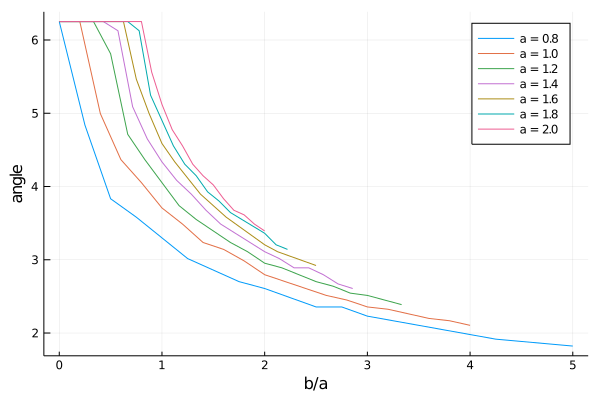

In [56]:
plot()
for (i, row) in enumerate(eachrow(widths))
    plot!(b_array[i,:]./a_array[i,1], row, label="a = $(a_array[i,1])")
end
plot!(xlabel="b/a", ylabel="angle")

Again, as before, we try to find a analytical expression for the things going on. Using a the same approach we get:
$$<\Delta U(\phi_i)> = a - \frac{b}{2\pi} \int_{-\phi_i}^{\Theta - \phi_i}|sin(\frac{x}{2})|- \frac{\Theta}{2\pi}c$$

in this case, we set $c=1$ as well as $a\rightarrow\frac{a}{c}$ and $b\rightarrow\frac{b}{c}$, resulting in:
$$<\Delta U(\phi_i)> = a - \frac{b}{2\pi} \int_{-\phi_i}^{\Theta - \phi_i}|sin(\frac{x}{2})|- \frac{\Theta}{2\pi}$$

Again we get the same rules for the edges of the Step Function, when a and b are given:
$<\Delta U> > 0$ in the sharing regime,
$<\Delta U> < 0$ in the non sharing regime,
$<\Delta U> = 0$ at the Border.

we can solve $\Delta U(\Theta, \phi_i, a, b)=0$ with $<\Delta U (\Theta, 0, a, b)=0$ for given a and b, to get the coresponding sharing Angle.

Expressed in formula, to find the width at a given a and b, we need to solve the equation:
$$a = \frac{b}{2\pi} \int_{0}^{\Theta}|sin(\frac{x}{2})|+ \frac{\Theta}{2\pi}$$
for $\Theta$.

In [57]:
f(Θ, ϕ, a, b) = a-b/2pi * quadgk(x -> abs(sin(x/2)), -ϕ, Θ-ϕ)[1] - Θ/2pi

f (generic function with 1 method)

In [58]:
get_Θ(a, b) = find_zero(x->f(x, 0, a, b), 2)

get_Θ (generic function with 1 method)

we can get the critical values at which the system goes from a total sharing state into a partial sharing state:

In [59]:
get_crit(a) = find_zero(x->f(2pi, 0, a, x), 2)

get_crit (generic function with 1 method)

In [60]:
critical_values = get_crit.(0.8:0.2:2.0)

7-element Array{Float64,1}:
 -0.3141592653589792
  0.0
  0.3141592653589793
  0.6283185307179585
  0.9424777960769378
  1.2566370614359175
  1.5707963267948963

obviously, at the border between sharing and not sharing, the value of c represents an offset which counteracts the financial incentive. We can therefore subtract the critical value of b from the x data, to overlay the beginnings of the curve nicely. To be able to compare the resulting data to the data for the case without inconvenience, it would be good to have b in units of a, as well as a in units of a. We get for the x data: $$x = \frac{b-critical\_value(a)}{a}$$
plotting the widths against this x:

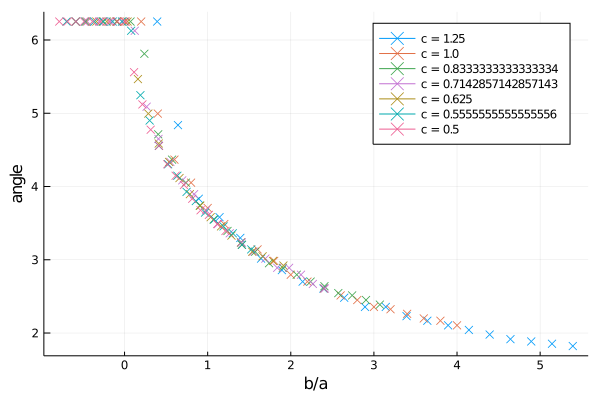

In [61]:
plot()
for (i, row) in enumerate(eachrow(widths))
    plot!((b_array[i,:].-critical_values[i])./a_array[i,1], row, label="c = $(1/a_array[i,1])", marker=:x, lw=0)
end
plot!(xlabel="b/a", ylabel="angle")

### they allign!

#### or do they?

In [62]:
test_ana = [6.2517693806436885
6.2517693806436885
6.2517693806436885
6.2517693806436885
6.2517693806436885
6.2517693806436885
6.2517693806436885
6.2517693806436885
5.717698629533423
4.775220833456486
4.335397861953915
3.989822670059037
3.7384952577718535
3.518583772020569
3.3615041393410787
3.2044245066615886
3.078760800517998
2.9530970943744057
2.8588493147667116
2.7646015351590183
2.6703537555513246
2.5761059759436304
2.5132741228718345
2.450442269800038
2.387610416728243
2.3561944901923453
2.293362637120549
2.230530784048753
2.199114857512855
2.1676989309769574
2.1048670779051615]

31-element Array{Float64,1}:
 6.2517693806436885
 6.2517693806436885
 6.2517693806436885
 6.2517693806436885
 6.2517693806436885
 6.2517693806436885
 6.2517693806436885
 6.2517693806436885
 5.717698629533423
 4.775220833456486
 4.335397861953915
 3.989822670059037
 3.7384952577718535
 ⋮
 2.7646015351590183
 2.6703537555513246
 2.5761059759436304
 2.5132741228718345
 2.450442269800038
 2.387610416728243
 2.3561944901923453
 2.293362637120549
 2.230530784048753
 2.199114857512855
 2.1676989309769574
 2.1048670779051615

comparing the results to the case with no inconvenience:

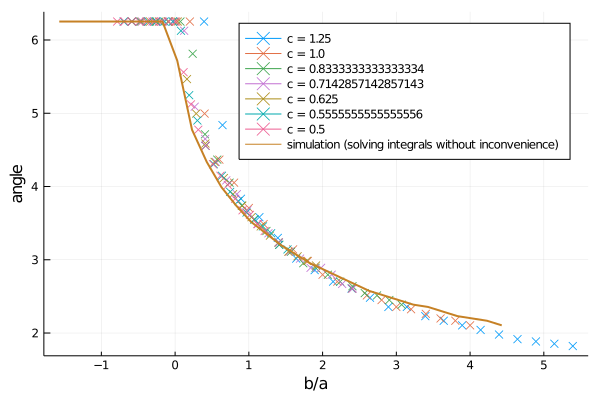

In [63]:
plot!(collect(0:0.2:6).-pi/2, test_ana, width=2, label="simulation (solving integrals without inconvenience)")

it seems as if the two curves are not exactly equal.

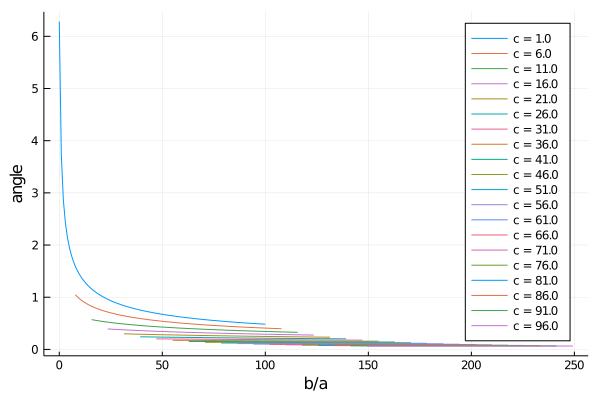

In [64]:
plot()
for a in [1/x for x in 1:5:100]
    b = 0:a:a*100
    angles = get_Θ.(a, b)
    angles[angles.>2π] .= 2π
    crit = get_crit(a)
    plot!((b.-crit)./a, angles, label="c = $(1/a)")
end
plot!(xlabel="b/a", ylabel="angle")

In [65]:
function f_c(Θ, ϕ, b, c)
    1-b/2pi * quadgk(x -> abs(sin(x/2)), -ϕ, Θ-ϕ)[1] - (Θ/2pi) * c
end

f_c (generic function with 1 method)

In [66]:
get_Θ_c(b, c) = find_zero(x->f_c(x, 0, b, c), 2)

get_Θ_c (generic function with 1 method)

In [67]:
get_crit_b(c) = find_zero(x->f_c(2π, 0, x, c),1)

get_crit_b (generic function with 1 method)

1.5707963267948966
1.5707963267948966
1.2566370614359172
1.2566370614359172
0.9424777960769378
0.9424777960769379
0.6283185307179586
0.6283185307179586
0.31415926535897926
0.31415926535897926
0.0
0.0
-0.3141592653589792
-0.31415926535897926
-0.6283185307179586
-0.6283185307179585
-0.9424777960769379
-0.942477796076938
-1.2566370614359172
-1.2566370614359172
-1.5707963267948968
-1.5707963267948966


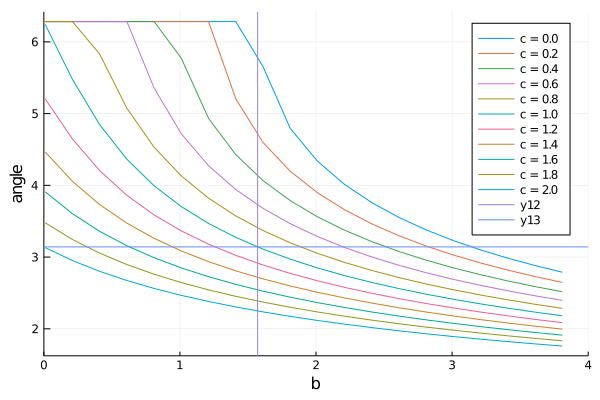

In [68]:
plot()
for c in 0:0.2:2
    crit = get_crit_b(c)
    println(crit)
    println(pi/2 * (1-c))
    b = 0.01:0.2:4
    angles = get_Θ_c.(b, c)
    angles[angles.>2π] .= 2π
    #plot!((b.-crit)./a, angles, label="c = $(1/a)")
    plot!(b, angles, label="c = $c")
end
vline!([pi/2])
hline!([pi])
plot!(xlabel="b", ylabel="angle")
#plot!(ylim=(3.1,3.2), xlim=(1.5,1.7))
plot!(xlim=(0,4))

In [69]:
dir2 = "2_player_full_comparable_scale/"
filenames2 = readdir(dir2)
filenames2 = [x for x in filenames2 if x[end-3:end] == "jld2"];

In [70]:
c_array2 = []
b_array2 = []
share_array2 = []
match_array2 = []

for file in filenames2
    result2 = load_sim(dir2*file)
    c = result2[2].c
    b = result2[2].b
    dt = result2[2].dt
    if c < 10
        if ((b in [0, 0.2, 0.4]) & (dt == 5)) | (b>0.4)
            push!(b_array2, b)
            push!(c_array2, c)
            push!(share_array2, result2[1][1])
            push!(match_array2, result2[1][2])
        end
    end
end

sorted = sortperm(c_array2)
print(c_array2[sorted])
c_array2 = reshape(c_array2[sorted], 21, :)
b_array2 = reshape(b_array2[sorted], 21, :)
share_array2 = reshape(share_array2[sorted], 21, :)
match_array2 = reshape(match_array2[sorted], 21, :);

Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1

In [71]:
c_array2

21×11 Array{Any,2}:
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6  1.8  2.0
 0.0  0.2  0.4  0.6  0.8  1.0  1.2  1.4  1.6 

In [72]:
b_array2

21×11 Array{Any,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4
 0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
 0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2
 1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4  1.4
 1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6  1.6
 1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2  2.2
 2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4  2.4
 2.6  2.6  2.6  2.6  2.6  2.6  2.6  2.6  2.6  2.6  2.6
 2.8  2.8  2.8  2.8  2.8  2.8  2.8  2.8  2.8  2.8  2.8
 3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
 3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2  3.2
 3.4  3.4  3.4  3.4  3.4  3.4  3.4  3.4  3.4 

In [73]:
test_result2 = hvcat(21, share_array2...);

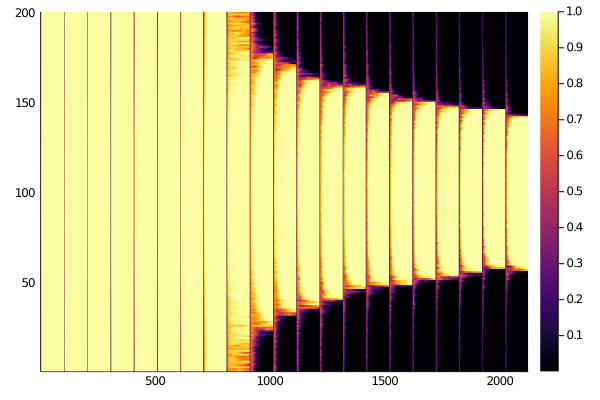

In [74]:
heatmap(hcat(share_array2[1:21]...))

In [75]:
heatmap(test_result2, xlabel="b", ylabel="c")

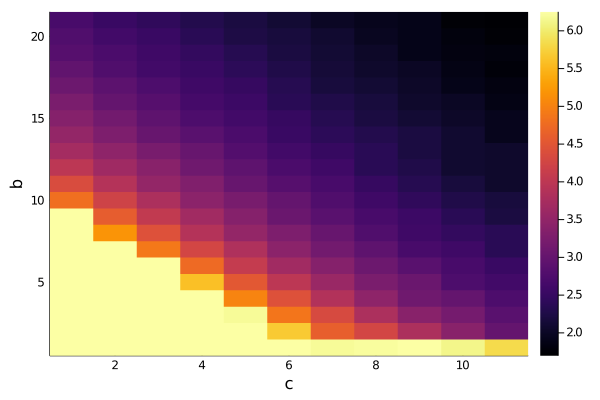

In [76]:
widths2 = zeros(size(share_array2))

ϕ_res2 = size(share_array2[1])[1]
ϕ2 = LinRange(0,2π, ϕ_res2+1)[1:end-1]

for (i, x) in enumerate(share_array2)
    params = simple_fitting(ϕ2, x[:,end])
    widths2[i] = (params[2] - params[1])
end
widths2 = reshape(widths2, 21, :)
heatmap(widths2, xlabel="c", ylabel="b")

1.5707963267948966
0.9424777960769379
0.31415926535897926
-0.31415926535897926
-0.942477796076938
-1.5707963267948966


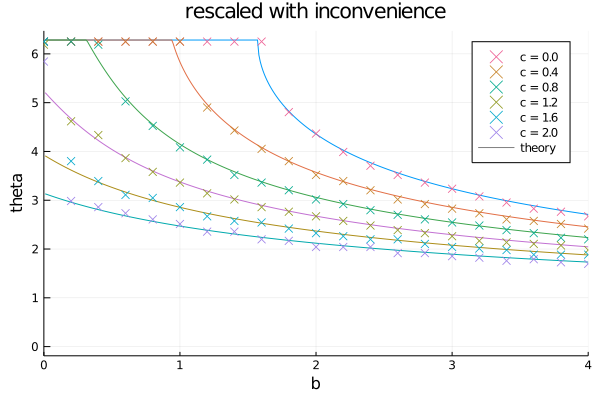

In [95]:
plot()
for c in 0:0.4:2
    crit = get_crit_b(c)
    println(pi/2 * (1-c))
    b = 0.01:0.01:4
    angles = get_Θ_c.(b, c)
    angles[angles.>2π] .= 2π
    plot!(b, angles, label="")
end

scatter!(b_array2[1:end,1], widths2[1:end,1:2:end], labels=permutedims(["c = $i" for i in c_array2[1,1:2:end]]), marker=:x)
plot!([0,0], [0,0], label="theory", color=:grey, width=0)
plot!(xlim=(0,4), title="rescaled with inconvenience", xlabel="b", ylabel="theta")


In [84]:
permutedims(["c = $i" for i in c_array2[1,1:2:end]])

1×6 Array{String,2}:
 "c = 0.0"  "c = 0.4"  "c = 0.8"  "c = 1.2"  "c = 1.6"  "c = 2.0"